# Importing libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Read datasets

In [ ]:
train_data = pd.read_table('/content/drive/MyDrive/Datasets/LIAR/train.tsv', names = ["id", "label", "statement", "subject", "speaker", "job", "state", "party",
                                            "barely-true", "false", "half-true", "mostly-true", "pants-fire", "venue"])

val_data = pd.read_table('/content/drive/MyDrive/Datasets/LIAR/valid.tsv', names = ["id", "label", "statement", "subject", "speaker", "job", "state", "party",
                                            "barely-true", "false", "half-true", "mostly-true", "pants-fire", "venue"])

test_data = pd.read_table('/content/drive/MyDrive/Datasets/LIAR/train.tsv', names = ["id", "label", "statement", "subject", "speaker", "job", "state", "party",
                                            "barely-true", "false", "half-true", "mostly-true", "pants-fire", "venue"])


In [ ]:
print(train_data.shape, test_data.shape,val_data.shape);
print(train_data.label.unique());
train_data.head()

(10240, 14) (10240, 14) (1284, 14)
['false' 'half-true' 'mostly-true' 'true' 'barely-true' 'pants-fire']


,id,label,statement,subject,speaker,job,state,party,barely-true,false,half-true,mostly-true,pants-fire,venue
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


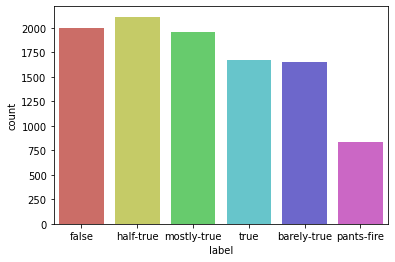

In [ ]:
def check_dist(dataset):
  sns.countplot(x='label', data=train_data, palette='hls')

check_dist(train_data)

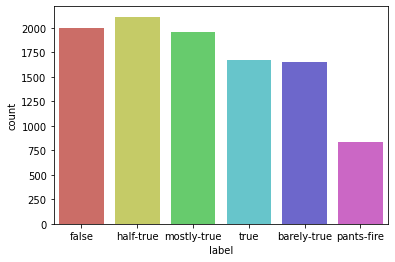

In [ ]:
check_dist(test_data)

In [ ]:
# Add flag to track fake and real

y_label_dict = {"pants-fire" : 0, "false" : 0, "barely-true" : 0, "half-true" : 1, "mostly-true" : 1, "true" : 1}
print(y_label_dict)

train_data['Target'] = train_data['label'].apply(lambda x: y_label_dict[x])
val_data['Target'] = val_data['label'].apply(lambda x: y_label_dict[x])
test_data['Target'] = test_data['label'].apply(lambda x: y_label_dict[x])

train_data.head()

{'pants-fire': 0, 'false': 0, 'barely-true': 0, 'half-true': 1, 'mostly-true': 1, 'true': 1}


,id,label,statement,subject,speaker,job,state,party,barely-true,false,half-true,mostly-true,pants-fire,venue,Target
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,0
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,1
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,1
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,0
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,1


In [ ]:
# Concatenate dataframes

data = pd.concat([train_data,test_data,val_data]);
data.shape

(21764, 15)

In [ ]:
# Shuffle the data

from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [ ]:
# Check the data

data.head()

,id,label,statement,subject,speaker,job,state,party,barely-true,false,half-true,mostly-true,pants-fire,venue,Target
0,579.json,mostly-true,"Obama ""hasn't been to Iraq in years.""",iraq,john-mccain,U.S. senator,Arizona,republican,31.0,39.0,31.0,37.0,8.0,a television ad,1
1,9181.json,barely-true,My state of Florida is now the third-largest s...,"census,states",bill-nelson,NaN,Florida,democrat,3.0,1.0,8.0,10.0,0.0,remarks at a committee hearing,0
2,7533.json,pants-fire,Of every three dollars in food stamps for the ...,"federal-budget,poverty",michele-bachmann,Congresswoman,Minnesota,republican,8.0,22.0,6.0,4.0,16.0,a speech at the conservative CPAC conference,0
3,7453.json,mostly-true,About two-thirds of all consumption is service...,"state-budget,taxes",joseph-testa,Ohio tax commissioner,Ohio,republican,0.0,0.0,0.0,1.0,0.0,a news conference,1
4,277.json,mostly-true,I took on the worst road system in the country...,job-accomplishments,mike-huckabee,author,Arkansas,republican,12.0,5.0,9.0,3.0,4.0,"a debate in Myrtle Beach, S.C.",1


Target
0     9592
1    12172
Name: statement, dtype: int64


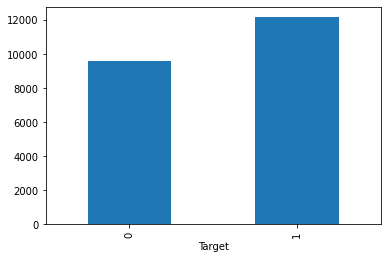

In [ ]:
print(data.groupby(['Target'])['statement'].count())
data.groupby(['Target'])['statement'].count().plot(kind="bar")
plt.show()

In [ ]:
# How many articles per subject?


print(data.groupby(['subject'])['statement'].count())

subject
Alcohol                                            8
Alcohol,animals,children,crime                     2
Alcohol,campaign-finance,ethics,public-service     2
Alcohol,candidates-biography                       2
Alcohol,candidates-biography,crime                 2
                                                  ..
welfare                                           25
welfare,workers                                    2
women                                             18
women,workers                                      4
workers                                           25
Name: statement, Length: 4190, dtype: int64


#Data cleaning & Preprocessing

In [ ]:
# Removing the id (we won't use it for the analysis - Feature Reduction)

data.drop(["id"],axis=1,inplace=True)
data.head()

,label,statement,subject,speaker,job,state,party,barely-true,false,half-true,mostly-true,pants-fire,venue,Target
0,mostly-true,"Obama ""hasn't been to Iraq in years.""",iraq,john-mccain,U.S. senator,Arizona,republican,31.0,39.0,31.0,37.0,8.0,a television ad,1
1,barely-true,My state of Florida is now the third-largest s...,"census,states",bill-nelson,NaN,Florida,democrat,3.0,1.0,8.0,10.0,0.0,remarks at a committee hearing,0
2,pants-fire,Of every three dollars in food stamps for the ...,"federal-budget,poverty",michele-bachmann,Congresswoman,Minnesota,republican,8.0,22.0,6.0,4.0,16.0,a speech at the conservative CPAC conference,0
3,mostly-true,About two-thirds of all consumption is service...,"state-budget,taxes",joseph-testa,Ohio tax commissioner,Ohio,republican,0.0,0.0,0.0,1.0,0.0,a news conference,1
4,mostly-true,I took on the worst road system in the country...,job-accomplishments,mike-huckabee,author,Arkansas,republican,12.0,5.0,9.0,3.0,4.0,"a debate in Myrtle Beach, S.C.",1


In [ ]:
df = data
df.isnull().sum()

label             0
statement         0
subject           4
speaker           4
job            6139
state          4695
party             4
barely-true       4
false             4
half-true         4
mostly-true       4
pants-fire        4
venue           216
Target            0
dtype: int64

In [ ]:
df = df.dropna()
df.isnull().sum()

label          0
statement      0
subject        0
speaker        0
job            0
state          0
party          0
barely-true    0
false          0
half-true      0
mostly-true    0
pants-fire     0
venue          0
Target         0
dtype: int64

In [ ]:
data = df.drop(["label","job","speaker","subject","state","party","venue","barely-true","false","half-true","mostly-true","pants-fire"],axis=1)

data.head()

,statement,Target
0,"Obama ""hasn't been to Iraq in years.""",1
2,Of every three dollars in food stamps for the ...,0
3,About two-thirds of all consumption is service...,1
4,I took on the worst road system in the country...,1
6,"A DWI costs $17,000.",0


In [ ]:
# Convert to lowercase

data['statement'] = data['statement'].apply(lambda x: x.lower())
data.head()

,statement,Target
0,says danny tarkanian is nra frated.,1
1,"says a youtube video shows thomas dimassimo, t...",1
2,"500,000 people have signed up for #obamacare.",1
3,were losing now over $500 billion a year in te...,0
6,because of barack obama the mission in iraq en...,1


In [ ]:
# Remove punctuation

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['statement'] = data['statement'].apply(punctuation_removal)
data.head()

,statement,Target
0,Obama hasnt been to Iraq in years,1
2,Of every three dollars in food stamps for the ...,0
3,About twothirds of all consumption is services...,1
4,I took on the worst road system in the country...,1
6,A DWI costs 17000,0


In [ ]:
# Removing stopwords

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['statement'] = data['statement'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
data.head()

,statement,Target
0,Obama hasnt Iraq years,1
2,Of every three dollars food stamps needy seven...,0
3,About twothirds consumption services It opposi...,1
4,I took worst road system country according Tru...,1
6,A DWI costs 17000,0


#Text Feature Selection using Information Gain 






In [ ]:
!pip install TextFeatureSelection

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import pandas as pd
import logging
# Evaluate the model
import sklearn
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import chi2
from TextFeatureSelection import TextFeatureSelection, TextFeatureSelectionGA

In [ ]:
data = pd.DataFrame(columns=['statement', 'Target'], data=data[['statement', 'Target']].values)

In [ ]:
fsOBJ=TextFeatureSelection(target=data['Target'].tolist(),input_doc_list=data['statement'].tolist(),metric_list='IG')
result_df=fsOBJ.getScore()
print(result_df)

         word list  word occurence count  Information Gain
0              004                     1          0.000000
1              005                     2          0.000000
2               01                     4          0.000002
3               02                     2          0.000000
4               03                     2          0.000041
...            ...                   ...               ...
10996        zones                     4          0.000002
10997       zoning                     4          0.000000
10998          zoo                     2          0.000000
10999  zuckerbergs                     2          0.000041
11000        zvisa                     1          0.000020

[11001 rows x 3 columns]


In [ ]:
result_df = result_df.sort_values(by=['Information Gain'], ascending=False)

print(result_df)

      word list  word occurence count  Information Gain
7420    percent                  1458          0.002258
9114      since                   517          0.001334
6918  obamacare                   272          0.001016
4772       half                   210          0.000995
8757       says                  3272          0.000956
...         ...                   ...               ...
7216      ozone                     5          0.000000
7215     oyster                     2          0.000000
7214      oxide                     2          0.000000
2625  considers                     2          0.000000
0           004                     1          0.000000

[11001 rows x 3 columns]


In [ ]:
def adjust_features(training_data, final_features, percentage = 60):
    length = int((percentage/100) * len(final_features))
    required_features = final_features[0:length]
    temp_data = pd.DataFrame()
    for index, row in training_data.iterrows():
        text = row['statement'].lower()
        text_tokens = word_tokenize(text)
        tokens_without_sw = [word for word in text_tokens if word in final_features]
        filtered_sentence = (" ").join(tokens_without_sw)
        temp_data = temp_data.append(pd.Series([filtered_sentence, row['Target']]), ignore_index=True)
    return temp_data

In [ ]:
import nltk
nltk.download('punkt')

final_data = adjust_features(data,result_df['word list'].to_list(),60)
print(final_data)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


                                                       0    1
0                                 obama hasnt iraq years  1.0
1      of every three dollars food stamps needy seven...  0.0
2      about twothirds consumption services it opposi...  1.0
3      took worst road system country according truck...  1.0
4                                        dwi costs 17000  0.0
...                                                  ...  ...
14304  says about 10 oregons inmates prison violent c...  1.0
14305  ninetyfive percent oregonians health insurance...  1.0
14306  on federal minimum wage 775 cant even make hal...  0.0
14307  hitler abolished unions thats wisconsin gov sc...  0.0
14308  gas tax holiday would best provide 30 cents da...  1.0

[14309 rows x 2 columns]


In [ ]:
final_data.columns= ['statement', 'Target']
final_data

,statement,Target
0,obama hasnt iraq years,1.0
1,of every three dollars food stamps needy seven...,0.0
2,about twothirds consumption services it opposi...,1.0
3,took worst road system country according truck...,1.0
4,dwi costs 17000,0.0
...,...,...
14304,says about 10 oregons inmates prison violent c...,1.0
14305,ninetyfive percent oregonians health insurance...,1.0
14306,on federal minimum wage 775 cant even make hal...,0.0
14307,hitler abolished unions thats wisconsin gov sc...,0.0


# Data Exploration after Preprocessing and Feature Selection

Target
0.0    5977
1.0    8332
Name: statement, dtype: int64


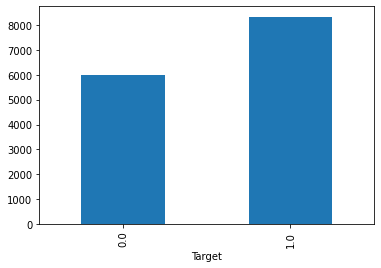

In [ ]:
# How many fake and real articles?


print(final_data.groupby(['Target'])['statement'].count())
final_data.groupby(['Target'])['statement'].count().plot(kind="bar")
plt.show()

In [ ]:
# Most frequent words counter 


from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()


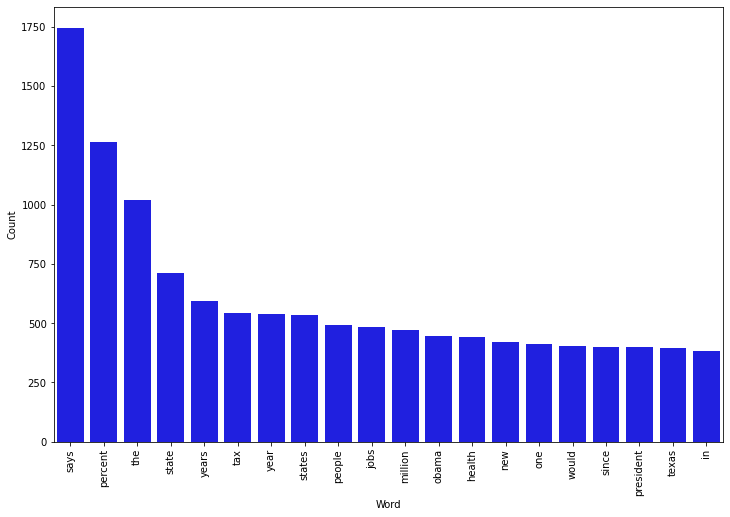

In [ ]:
# Most frequent words in real news

counter(final_data[data["Target"] == 1], "statement", 20)

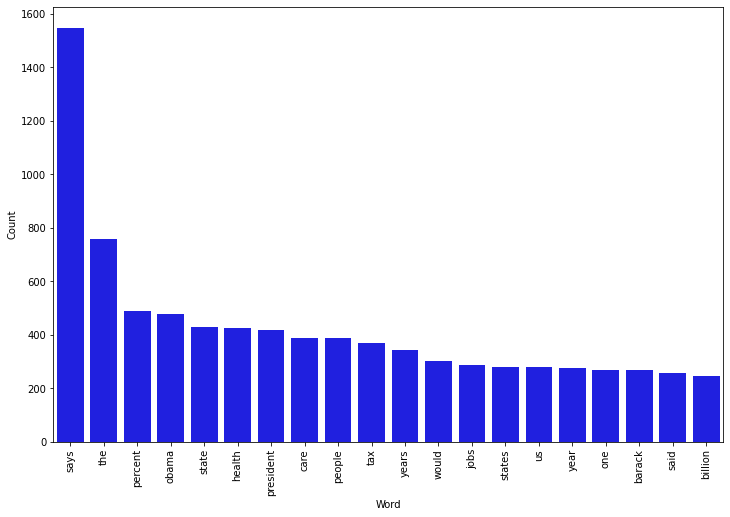

In [ ]:
# Most frequent words in fake news

counter(final_data[data["Target"] == 0], "statement", 20)


In [ ]:
!pip install transformers
!pip install simpletransformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 52.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 69.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 23.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.5/250.5 KB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 44.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 94.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 62.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

#BERT 

In [ ]:
from simpletransformers.classification import ClassificationModel
import pandas as pd
import logging


logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

In [ ]:
# splitting the data into training and test dataset
X = final_data['statement']
y = final_data['Target']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
train_df = pd.DataFrame(X_train)
train_df['target'] = y_train

eval_df = pd.DataFrame(X_test)
eval_df['target'] = y_test

In [ ]:
train_df.shape, eval_df.shape

((11447, 2), (2862, 2))

In [ ]:
# Create a ClassificationModel

from simpletransformers.classification import ClassificationModel
model = ClassificationModel('bert', 'bert-base-cased',args={'num_train_epochs':3, 'train_batch_size':16} ) # You can set class weights by using the optional weight argument

# Train the model
model.train_model(train_df)

# Evaluate the model
import sklearn


result, model_outputs, wrong_predictions = model.eval_model(eval_df, acc=sklearn.metrics.accuracy_score)
result

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

  0%|          | 0/11447 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/716 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/716 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/716 [00:00<?, ?it/s]

  0%|          | 0/2862 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/358 [00:00<?, ?it/s]

{'mcc': 0.7083705488219781,
 'tp': 1476,
 'tn': 981,
 'fp': 214,
 'fn': 191,
 'auroc': 0.9195975030935235,
 'auprc': 0.9327048913627977,
 'acc': 0.8584905660377359,
 'eval_loss': 0.4533266651563804}

In [ ]:
result

{'mcc': 0.7083705488219781,
 'tp': 1476,
 'tn': 981,
 'fp': 214,
 'fn': 191,
 'auroc': 0.9195975030935235,
 'auprc': 0.9327048913627977,
 'acc': 0.8584905660377359,
 'eval_loss': 0.4533266651563804}

In [ ]:
print(model_outputs)

[[-2.5703125   1.65722656]
 [-2.63476562  1.75976562]
 [ 0.62402344 -1.51171875]
 ...
 [-2.28710938  1.66015625]
 [-1.78320312  1.24804688]
 [-2.68164062  1.85644531]]


In [ ]:
lst = []
for arr in model_outputs:
    lst.append(np.argmax(arr))

In [ ]:
true = eval_df['target'].tolist()
predicted = lst

In [ ]:
import sklearn
dct = dict()
mat = sklearn.metrics.confusion_matrix(true , predicted)
print('Accuracy =',accuracy_score(true , predicted))
dct['BERT'] = round(accuracy_score(true , predicted)*100,2)
mat

Accuracy = 0.8584905660377359


array([[ 981,  214],
       [ 191, 1476]])

In [ ]:
print(sklearn.metrics.classification_report(true,predicted,target_names=['FAKE','REAL']))

              precision    recall  f1-score   support

        FAKE       0.84      0.82      0.83      1195
        REAL       0.87      0.89      0.88      1667

    accuracy                           0.86      2862
   macro avg       0.86      0.85      0.85      2862
weighted avg       0.86      0.86      0.86      2862



#RNN and LSTM

In [ ]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot

In [ ]:
def embed_features(t, sen_len, vocal_size):
       onehot_repr = [one_hot(sen, vocal_size) for sen in t]
       embedded_docs = pad_sequences(onehot_repr, padding='pre', maxlen=sen_len)
       print(embedded_docs)
       return embedded_docs

In [ ]:
voc_size = 5000
s_len = 20
embedded_docs = embed_features(final_data['statement'], vocal_size=voc_size, sen_len=s_len)

[[   0    0    0 ... 1204 2706 3670]
 [   0    0    0 ... 4046 2981  851]
 [   0    0    0 ... 1985 4678 4156]
 ...
 [   0    0    0 ... 3530 3644 4369]
 [   0    0    0 ... 2408 2707 3754]
 [   0    0    0 ... 4216 4735 4817]]


In [ ]:
X_lstm = np.array(embedded_docs)
Y_lstm = np.array(final_data.Target)

In [ ]:
#Creating the model
embedded_vector_features = 40
model = Sequential()
model.add(Embedding(voc_size, embedded_vector_features, input_length=s_len))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

#Compiling the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 40)            200000    
                                                                 
 dropout_2 (Dropout)         (None, 20, 40)            0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               56400     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
#Spliting the data into training and testing data
X_lstm_train, X_lstm_test, Y_lstm_train, Y_lstm_test = train_test_split(X_lstm, Y_lstm, test_size=0.20, random_state=42)

In [ ]:
#fitting the model
history = model.fit(X_lstm_train, Y_lstm_train, validation_data=(X_lstm_test, Y_lstm_test), epochs=10, batch_size=64)

Epoch 1/10
179/179 [==============================] - 13s 54ms/step - loss: 0.6612 - accuracy: 0.5995 - val_loss: 0.6176 - val_accuracy: 0.6649
Epoch 2/10
179/179 [==============================] - 5s 28ms/step - loss: 0.5469 - accuracy: 0.7286 - val_loss: 0.5713 - val_accuracy: 0.7068
Epoch 3/10
179/179 [==============================] - 4s 24ms/step - loss: 0.4352 - accuracy: 0.8031 - val_loss: 0.5465 - val_accuracy: 0.7324
Epoch 4/10
179/179 [==============================] - 2s 10ms/step - loss: 0.3390 - accuracy: 0.8550 - val_loss: 0.5614 - val_accuracy: 0.7648
Epoch 5/10
179/179 [==============================] - 2s 9ms/step - loss: 0.2737 - accuracy: 0.8875 - val_loss: 0.5422 - val_accuracy: 0.7952
Epoch 6/10
179/179 [==============================] - 2s 10ms/step - loss: 0.2312 - accuracy: 0.9067 - val_loss: 0.5686 - val_accuracy: 0.8106
Epoch 7/10
179/179 [==============================] - 2s 10ms/step - loss: 0.1925 - accuracy: 0.9216 - val_loss: 0.5474 - val_accuracy: 0.8229

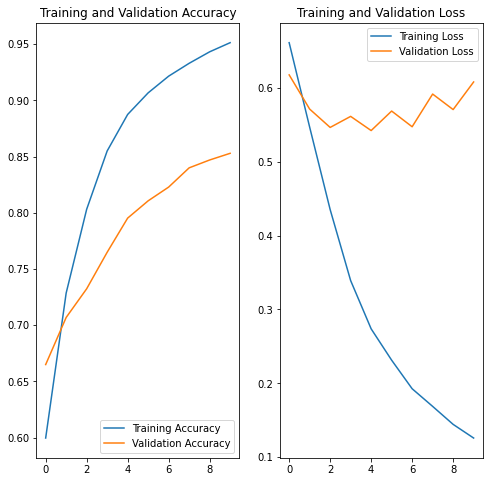

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.save("model_h1.h5")

In [ ]:
model.evaluate(X_lstm_test, Y_lstm_test)

90/90 [==============================] - 0s 5ms/step - loss: 0.6080 - accuracy: 0.8529


[0.6080171465873718, 0.8529000878334045]

In [ ]:
# Function to plot the confusion matrix 
# (code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)


from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

90/90 [==============================] - 1s 4ms/step
Confusion matrix, without normalization
[[ 960  208]
 [ 213 1481]]
0.8529000698812019


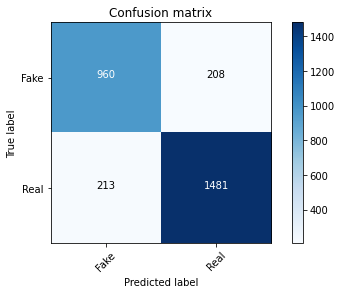

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score

Y_lstm_predict = (model.predict(X_lstm_test) > 0.5).astype("int32");
c_matix = confusion_matrix(Y_lstm_test, Y_lstm_predict)
plot_confusion_matrix(c_matix, classes=['Fake', 'Real'])
accuracy = accuracy_score(Y_lstm_test, Y_lstm_predict)
dct['LSTM-RNN'] = round(accuracy_score(Y_lstm_test, Y_lstm_predict)*100,2)
print(c_matix)
print(accuracy)

# Basic Classification Models

In [ ]:
# Split the data

X_train,X_test,y_train,y_test = train_test_split(final_data['statement'],final_data.Target, test_size=0.20, random_state=21)


In [ ]:
# 1. Naive Bayes

from sklearn.naive_bayes import MultinomialNB
NB_classifier = MultinomialNB()

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', NB_classifier)])


# Fitting the model
model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)

# Accuracy
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

dct['Naive Bayes'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 70.79%


F1 score: 0.6842963972985519
Recall: 0.7078965758211041
Precision: 0.7346099258607339
Confusion matrix, without normalization


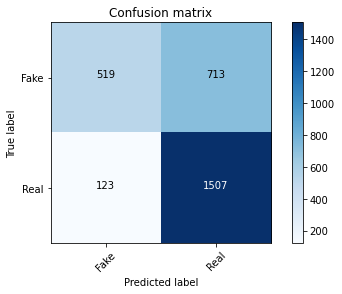

In [ ]:
# confusion matrix for Naive Bayes
from sklearn.metrics import f1_score, recall_score, precision_score 
print('F1 score:', f1_score(y_test, prediction,average='weighted'))
print('Recall:', recall_score(y_test, prediction,
                              average='weighted'))
print('Precision:', precision_score(y_test, prediction,
                                    average='weighted'))
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

In [ ]:
# 2. Logistic Regression


from sklearn.linear_model import LogisticRegression

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Logistic Regression'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 72.19%


F1 score: 0.712581330938293
Recall: 0.7218728162124388
Precision: 0.7259894330682501
Confusion matrix, without normalization


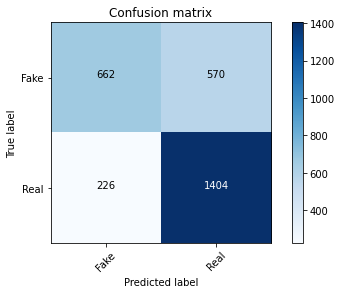

In [ ]:
# confusion matrix for Logistic Regression
from sklearn.metrics import f1_score, recall_score, precision_score 
print('F1 score:', f1_score(y_test, prediction,average='weighted'))
print('Recall:', recall_score(y_test, prediction,
                              average='weighted'))
print('Precision:', precision_score(y_test, prediction,
                                    average='weighted'))
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])


In [ ]:
# 1. Decision Tree 

from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Decision Tree'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 61.71%


F1 score: 0.5359330811763164
Recall: 0.6170510132774284
Precision: 0.6718534293152004
Confusion matrix, without normalization


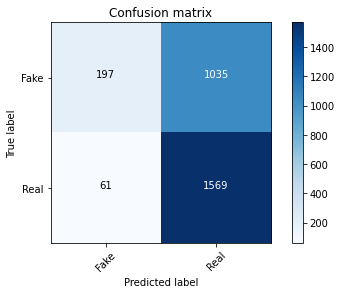

In [ ]:
# confusion matrix for Decision Tree
from sklearn.metrics import f1_score, recall_score, precision_score 
print('F1 score:', f1_score(y_test, prediction,average='weighted'))
print('Recall:', recall_score(y_test, prediction,
                              average='weighted'))
print('Precision:', precision_score(y_test, prediction,
                                    average='weighted'))
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

In [ ]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Random Forest'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 90.99%


F1 score: 0.9092742973536349
Recall: 0.909853249475891
Precision: 0.9110970488920905
Confusion matrix, without normalization


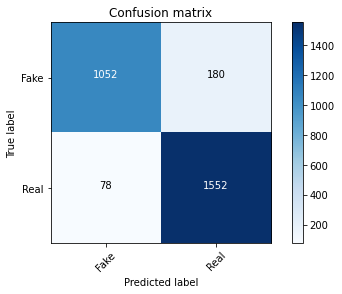

In [ ]:
from sklearn.metrics import f1_score, recall_score, precision_score 
print('F1 score:', f1_score(y_test, prediction,average='weighted'))
print('Recall:', recall_score(y_test, prediction,
                              average='weighted'))
print('Precision:', precision_score(y_test, prediction,
                                    average='weighted'))

cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# Comparing Different Models

([<matplotlib.axis.YTick at 0x7fc309f81e20>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

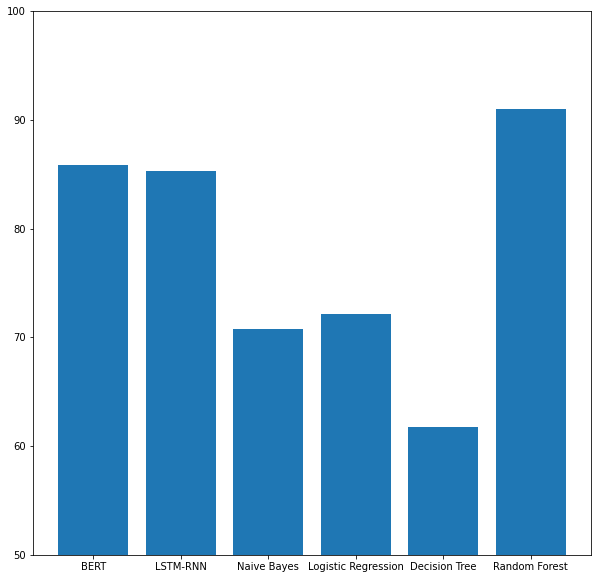

In [ ]:

plt.figure(figsize=(10,10))
plt.bar(list(dct.keys()),list(dct.values()))
plt.ylim(50,100)
plt.yticks((50, 60, 70, 80, 90, 100))